<a href="https://colab.research.google.com/github/henrique-sk/transfer-learning-cats-vs-dogs/blob/main/transfer_learning_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

This project is based on the tutorial [transfer-learning](https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb). All the content extracted from this project is formatted as a reference and the code has been reused for the most part, with some updates and variable imports. The [Dataset](https://www.microsoft.com/en-us/download/details.aspx?id=54765) used contains two classes: cats and dogs. The description of the dataset can be found [here](https://www.microsoft.com/en-us/download/details.aspx?id=54765). At the end I created a function for individual analysis of images, with some tests.

# Transfer learning / fine-tuning

Basically:
>transfer learning refers to the process of leveraging the knowledge learned in one model for the training of another model.

>More specifically, the process involves taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages that previous network's accuracy for a new task. This method has become popular in recent years to improve the performance of a neural net trained on a small dataset; the intuition is that the new dataset may be too small to train to good performance by itself, but we know that most neural nets trained to learn image features often learn similar features anyway, especially at early layers where they are more generic (edge detectors, blobs, and so on).

>Transfer learning has been largely enabled by the open-sourcing of state-of-the-art models; for the top performing models in image classification tasks (like from [ILSVRC](http://www.image-net.org/challenges/LSVRC/)), it is common practice now to not only publish the architecture, but to release the trained weights of the model as well. This lets amateurs use these top image classifiers to boost the performance of their own task-specific models.

#### Feature extraction vs. fine-tuning

>At one extreme, transfer learning can involve taking the pre-trained network and freezing the weights, and using one of its hidden layers (usually the last one) as a feature extractor, using those features as the input to a smaller neural net.

>At the other extreme, we start with the pre-trained network, but we allow some of the weights (usually the last layer or last few layers) to be modified. Another name for this procedure is called "fine-tuning" because we are slightly adjusting the pre-trained net's weights to the new task. We usually train such a network with a lower learning rate, since we expect the features are already relatively good and do not need to be changed too much.

## Procedure

>In this guide will go through the process of loading a state-of-the-art, 1000-class image classifier, [VGG16](https://arxiv.org/pdf/1409.1556.pdf) which [won the ImageNet challenge in 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), and using it as a fixed feature extractor to train a smaller custom classifier on our own images, although with very few code changes, you can try fine-tuning as well.

>We will first load VGG16 and remove its final layer, the 1000-class softmax classification layer specific to ImageNet, and replace it with a new classification layer for the classes we are training over. We will then freeze all the weights in the network except the new ones connecting to the new classification layer, and then train the new classification layer over our new dataset.

>We will also compare this method to training a small neural network from scratch on the new dataset, and as we shall see, it will dramatically improve our accuracy. We will do that part first.


In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras_preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Getting a dataset

I used the first 500 images of both cats and dogs from the database mentioned at the beginning. These two categories are in subfolders added to Google Drive and to use them all I had to do was mount the drive.

In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
root = '/content/drive/MyDrive/transfer-learning/PetImages/'
exclude = []
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['/content/drive/MyDrive/transfer-learning/PetImages/Dog', '/content/drive/MyDrive/transfer-learning/PetImages/Cat']


>This function is useful for pre-processing the data into an image and input vector. That images are being resized to 224x224.

In [4]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

>Load all the images from root folder

In [5]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

>Randomize the data order.

In [6]:
random.shuffle(data)

>create training / validation / test split (70%, 15%, 15%)

In [7]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

>Separate data for labels.

In [8]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]


>Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [9]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(150, 2)


>Let's get a summary of what we have.

In [10]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 1000 images from 2 categories
train / validation / test split: 700, 150, 150
training data shape:  (700, 224, 224, 3)
training labels shape:  (700, 2)


This loads the 1000 images,
>and split them into three sets: `train`, `val`, and `test`."

The form of the training data is (700, 224, 224, 3) where 700 is the size of the training set, and `c` is the number of classes (i.e. 2, being cats and dogs)

>Notice that we divided all the data into three subsets -- a training set `train`, a validation set `val`, and a test set `test`. The reason for this is to properly evaluate the accuracy of our classifier. During training, the optimizer uses the validation set to evaluate its internal performance, in order to determine the gradient without overfitting to the training set. The `test` set is always held out from the training algorithm, and is only used at the end to evaluate the final accuracy of our model.

>Let's quickly look at a few sample images from our dataset.

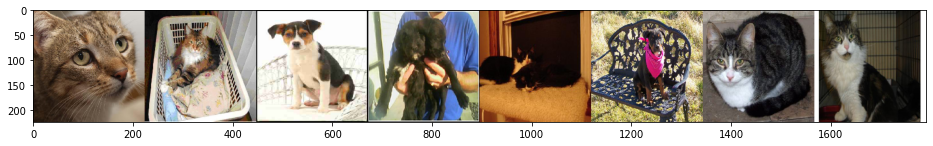

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### First training a neural net from scratch

>Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

>The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

>Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701).

>Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

In [12]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

>We've created a medium-sized network with ~1.2 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

I trained the model for 15 epochs
>with a batch size of 128. We'll also record its history so we can plot the loss over time later.

In [13]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_val, y_val))


Epoch 1/15
6/6 [==============================] - 53s 8s/step - loss: 0.7153 - accuracy: 0.4886 - val_loss: 0.6889 - val_accuracy: 0.5400
Epoch 2/15
6/6 [==============================] - 42s 7s/step - loss: 0.6904 - accuracy: 0.5329 - val_loss: 0.6889 - val_accuracy: 0.6133
Epoch 3/15
6/6 [==============================] - 41s 7s/step - loss: 0.6867 - accuracy: 0.5643 - val_loss: 0.6777 - val_accuracy: 0.6400
Epoch 4/15
6/6 [==============================] - 41s 7s/step - loss: 0.6689 - accuracy: 0.5886 - val_loss: 0.6541 - val_accuracy: 0.6400
Epoch 5/15
6/6 [==============================] - 42s 7s/step - loss: 0.6473 - accuracy: 0.6229 - val_loss: 0.6317 - val_accuracy: 0.5800
Epoch 6/15
6/6 [==============================] - 46s 8s/step - loss: 0.6376 - accuracy: 0.6257 - val_loss: 0.6438 - val_accuracy: 0.6000
Epoch 7/15
6/6 [==============================] - 41s 7s/step - loss: 0.6191 - accuracy: 0.6343 - val_loss: 0.6427 - val_accuracy: 0.5933
Epoch 8/15
6/6 [==================

>Let's plot the validation loss and validation accuracy over time.

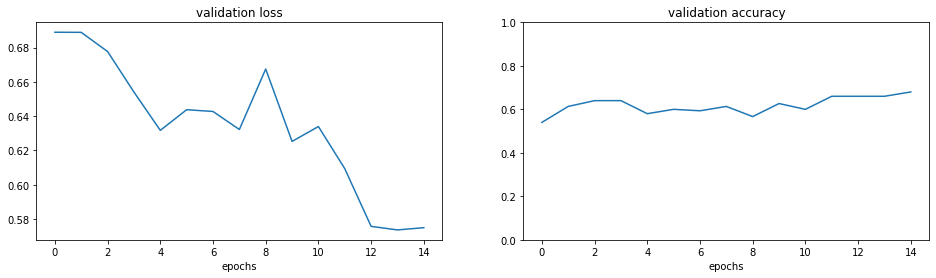

In [14]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

I noticed that the validation loss increases up to 6 epochs, stabilizes, and increases again after 10 epochs. And the validation accuracy increases slightly, from 54% to 68%, oscillating very slightly.

>We can also get a final evaluation by running our model on the training set. Doing so, we get the following results:

In [15]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6913583278656006
Test accuracy: 0.6200000047683716


Finally, if you notice the maximum accuracy (top-1) is 78%. A very good result, but considering that there are only two classes, it is a reasonable result, even if you have 500 images of each.

## Transfer learning by starting with existing network

>Now we can move on to the main strategy for training an image classifier on our small dataset: by starting with a larger and already trained network.

>To start, we will load the VGG16 from keras, which was trained on ImageNet and the weights saved online. If this is your first time loading VGG16, you'll need to wait a bit for the weights to download from the web. Once the network is loaded, we can again inspect the layers with the `summary()` method.

In [16]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

>Notice that VGG16 is _much_ bigger than the network we constructed earlier. It contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. Like our first network, the majority of the parameters are stored in the connections leading into the first fully-connected layer.

>In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains ...

... only 2 neurons in the case of the cats_vs_dogs dataset. 

>In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras `Model` class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called `new_classification_layer`. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [17]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


>We are going to retrain this network, `model_new` on the new dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new one at the end, with the expectation that the features that were learned in VGG should still be fairly relevant to the new image classification task. Not optimal, but most likely better than what we can train to in our limited dataset. 

>By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers. If your dataset has enough samples, and doesn't resemble ImageNet very much, it might be advantageous to fine-tune some of the VGG layers along with the new classifier, or possibly even all of them. To do this, you can change the below code to make more of the layers trainable.

>So we go ahead and freeze the layers, and compile the new model with exactly the same optimizer and loss function as in our first network, for the sake of a fair comparison. We then run `summary` again to look at the network's architecture.

In [18]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

>Looking at the summary, we see the network is identical to the VGG model we instantiated earlier, except the last layer, formerly a 1000-neuron softmax, has been replaced by a new ...

... 2-neuron softmax.

>Additionally, we still have roughly 134 million weights, but now the vast majority of them are "non-trainable params" because we froze the layers they are contained in. We now only have ...

... 8,194 trainable parameters.

>As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history as we go.

In [19]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=15, 
                         validation_data=(x_val, y_val))


Epoch 1/15
6/6 [==============================] - 422s 71s/step - loss: 0.9886 - accuracy: 0.5100 - val_loss: 0.5721 - val_accuracy: 0.7133
Epoch 2/15
6/6 [==============================] - 404s 69s/step - loss: 0.6166 - accuracy: 0.6629 - val_loss: 0.5392 - val_accuracy: 0.6867
Epoch 3/15
6/6 [==============================] - 423s 70s/step - loss: 0.5188 - accuracy: 0.7100 - val_loss: 0.5052 - val_accuracy: 0.7267
Epoch 4/15
6/6 [==============================] - 419s 71s/step - loss: 0.4418 - accuracy: 0.8329 - val_loss: 0.4259 - val_accuracy: 0.8067
Epoch 5/15
6/6 [==============================] - 419s 72s/step - loss: 0.4068 - accuracy: 0.8471 - val_loss: 0.3923 - val_accuracy: 0.8133
Epoch 6/15
6/6 [==============================] - 417s 71s/step - loss: 0.3745 - accuracy: 0.8671 - val_loss: 0.3754 - val_accuracy: 0.8467
Epoch 7/15
6/6 [==============================] - 420s 72s/step - loss: 0.3505 - accuracy: 0.8814 - val_loss: 0.3591 - val_accuracy: 0.8533
Epoch 8/15
6/6 [====

The validation accuracy hovers close to 90% towards the end, which is more than 13% improvement on the original network trained from scratch. 

>It's worth noting also that this network actually trains _slightly faster_ than the original network, despite having more than 100 times as many parameters! This is because freezing the weights negates the need to backpropagate through all those layers, saving us on runtime.

>Let's plot the validation loss and accuracy again, this time comparing the original model trained from scratch and the new transfer-learned model.

Blue -> Original model

Orange -> Transfer-learned


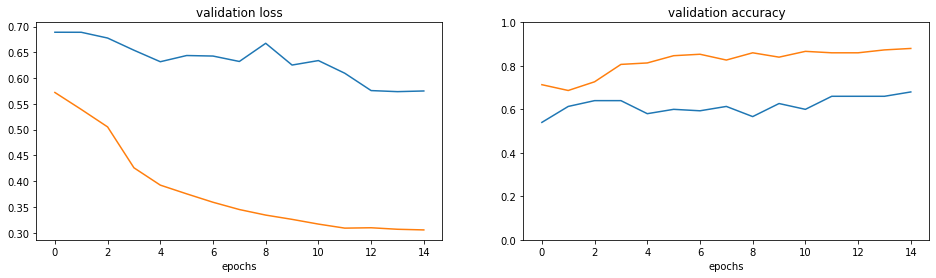

In [20]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Notice that whereas the original model began overfitting around epoch 12, the new model continued to slowly decrease its loss over time, and likely would have improved its accuracy slightly with more iterations. The new model made it to roughly 90% top-1 accuracy (in the validation set).

>Again, we do a final validation on the test set.

In [21]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.3950555920600891
Test accuracy: 0.8066666722297668


>To predict a new image, simply run the following code to get the probabilities for each class.

Since we only have two classes, in this case, the first refers to the chance of being a cat and the second to the chance of being a dog.

In [25]:
img, x = get_image('/content/drive/MyDrive/transfer-learning/PetImages/Cat/1.jpg') # random cat image from google
probabilities = model_new.predict([x])
probabilities

1/1 [==============================] - 1s 971ms/step


array([[7.7687745e-10, 1.0000000e+00]], dtype=float32)

I created this function to make the prediction of individual images.

In [27]:
def cat_or_dog(img_path):

  img, x = get_image(img_path)
  probabilities = model_new.predict([x])
  imshow(img)
  chance = probabilities[0][0] - probabilities[0][1]
  percent = str(abs(round((chance*100),2))).rstrip('0').rstrip('.')
  print(f"With {percent}% certainty it is a ...")
  if (chance < 0):
    animal = "CAT!!!"
  elif (chance > 0):
    animal = "DOG!!!"

  return animal

# Testing

I collected some random images on google to test.

Let's try with a cat.

1/1 [==============================] - 1s 555ms/step
With 100% certainty it is a ...


'CAT!!!'

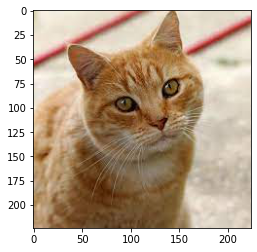

In [30]:
cat_or_dog('/content/drive/MyDrive/transfer-learning/TestImages/cat1.jpg')

Let's try with a dog.

1/1 [==============================] - 1s 548ms/step
With 100% certainty it is a ...


'DOG!!!'

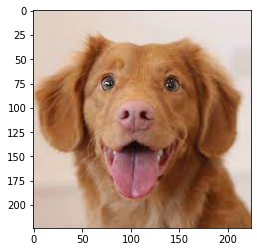

In [31]:
cat_or_dog('/content/drive/MyDrive/transfer-learning/TestImages/dog1.jpg')

Let's try with another cat.

1/1 [==============================] - 1s 530ms/step
With 50.45% certainty it is a ...


'CAT!!!'

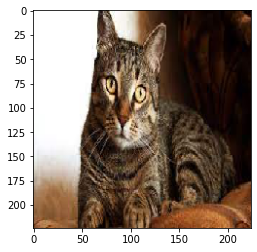

In [36]:
cat_or_dog('/content/drive/MyDrive/transfer-learning/TestImages/cat2.jpg')

The first two predictions got it right with 100% certainty, while the third was only 50.5% sure. During some tests I observed that the prediction of dogs performs better than that of cats. Possibly this could be minimized by using a larger amount of images during training.

But what if I test using a picture of my dog Joly?

1/1 [==============================] - 1s 552ms/step
With 100% certainty it is a ...


'DOG!!!'

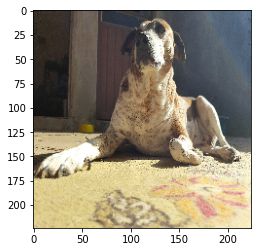

In [39]:
cat_or_dog('/content/drive/MyDrive/transfer-learning/TestImages/Joly.jpg')

Whew! She really is a dog!